<a href="https://colab.research.google.com/github/mafaldasalomao/pavic_treinamento_ml/blob/main/PAVIC_ML_15_PT_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compactação de imagens com autoencoders

## Etapa 1: Importação das bibliotecas

In [ ]:
from torchvision import datasets, transforms
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
torch.__version__

'2.0.1+cu118'

In [ ]:
torch.manual_seed(123)

## Etapa 2: Base de dados

In [ ]:
dataset_train = datasets.MNIST('MNIST-data', train = True, download = True,
                               transform = transforms.ToTensor())
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 256,
                                           shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 96845130.21it/s]


Extracting MNIST-data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST-data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 114171247.71it/s]


Extracting MNIST-data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST-data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26539358.37it/s]


Extracting MNIST-data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST-data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22126049.67it/s]


Extracting MNIST-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST-data/MNIST/raw



In [ ]:
dataset_val = datasets.MNIST('MNIST-data', train = False, download = True,
                             transform = transforms.ToTensor())
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 256,
                                         shuffle = True)

## Etapa 3: Construção do autoencoder

In [ ]:
28 * 28

784

In [ ]:
# 784 -> 32 -> 784
class autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.dense0 = nn.Linear(in_features=784, out_features=32)
    self.activation0 = nn.ReLU()
    self.dense1 = nn.Linear(32, 784)
    self.activation1 = nn.Sigmoid()

  def forward(self, X):
    X = X.view(-1, 28*28)
    X = self.dense0(X)
    X = self.activation0(X)
    X = self.dense1(X)
    X = self.activation1(X)
    return X

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
model = autoencoder()
model.to(device)

autoencoder(
  (dense0): Linear(in_features=784, out_features=32, bias=True)
  (activation0): ReLU()
  (dense1): Linear(in_features=32, out_features=784, bias=True)
  (activation1): Sigmoid()
)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

## Etapa 4: Treinamento do modelo

In [ ]:
for epoch in range(20):
    # Treinamento
    running_loss_train = 0.
    for data in loader_train:
      model.train()
      inputs, _ = data
      inputs = inputs.to(device)
      optimizer.zero_grad()
      outputs = model.forward(inputs)
      loss = criterion(outputs, inputs.view(*outputs.shape))
      loss.backward()
      optimizer.step()
      running_loss_train += loss.item()

    # Validação
    running_loss_val = 0.
    for data in loader_val:
      model.eval()
      inputs, _ = data
      inputs = inputs.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, inputs.view(*outputs.shape))
      running_loss_val += loss.item()

    # Final da época
    print('ÉPOCA {:3d}: perda_train {:.5f} perda_val {:.5f}'.format(epoch + 1, running_loss_train/len(loader_train), running_loss_val/len(loader_val)))

ÉPOCA   1: perda_train 0.29529 perda_val 0.19752
ÉPOCA   2: perda_train 0.18119 perda_val 0.16547
ÉPOCA   3: perda_train 0.15759 perda_val 0.14778
ÉPOCA   4: perda_train 0.14333 perda_val 0.13660
ÉPOCA   5: perda_train 0.13427 perda_val 0.12921
ÉPOCA   6: perda_train 0.12780 perda_val 0.12397
ÉPOCA   7: perda_train 0.12312 perda_val 0.11901
ÉPOCA   8: perda_train 0.11805 perda_val 0.11451
ÉPOCA   9: perda_train 0.11506 perda_val 0.11267
ÉPOCA  10: perda_train 0.11310 perda_val 0.11086
ÉPOCA  11: perda_train 0.11184 perda_val 0.10954
ÉPOCA  12: perda_train 0.11099 perda_val 0.10927
ÉPOCA  13: perda_train 0.11038 perda_val 0.10839
ÉPOCA  14: perda_train 0.11003 perda_val 0.10836
ÉPOCA  15: perda_train 0.10971 perda_val 0.10761
ÉPOCA  16: perda_train 0.10814 perda_val 0.10623
ÉPOCA  17: perda_train 0.10751 perda_val 0.10551
ÉPOCA  18: perda_train 0.10714 perda_val 0.10535
ÉPOCA  19: perda_train 0.10689 perda_val 0.10544
ÉPOCA  20: perda_train 0.10675 perda_val 0.10555


## Etapa 5: Geração do encoder

In [ ]:
list(model.children())

[Linear(in_features=784, out_features=32, bias=True),
 ReLU(),
 Linear(in_features=32, out_features=784, bias=True),
 Sigmoid()]

In [ ]:
list(model.children())[1]

ReLU()

In [ ]:
class encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.dense0 = list(model.children())[0]
    self.activation0 = list(model.children())[1]

  def forward(self, X):
    X = X.view(-1, 28*28)
    X = self.dense0(X)
    X = self.activation0(X)
    return X

In [ ]:
model1 = encoder()
model1.to(device)

encoder(
  (dense0): Linear(in_features=784, out_features=32, bias=True)
  (activation0): ReLU()
)

## Etapa 6: Geração do decoder

In [ ]:
list(model.children())[3]

Sigmoid()

In [ ]:
class decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.dense0 = list(model.children())[2]
    self.activation0 = list(model.children())[3]

  def forward(self, X):
    X = self.dense0(X)
    X = self.activation0(X)
    return X

In [ ]:
model2 = decoder()
model2.to(device)

decoder(
  (dense0): Linear(in_features=32, out_features=784, bias=True)
  (activation0): Sigmoid()
)

## Etapa 7: Visualização dos resultados

In [ ]:
numero_imagens = 10
imagens_teste = next(iter(loader_val))[0][:numero_imagens]
imagens_teste = imagens_teste.to(device)

In [ ]:
imagens_teste.shape

torch.Size([10, 1, 28, 28])

In [ ]:
# Imagens codificadas
model1.eval()
imagens_codificadas = model1(imagens_teste)

In [ ]:
imagens_codificadas.shape

torch.Size([10, 32])

In [ ]:
# Imagens decodificadas
model2.eval()
imagens_decodificadas = model2(imagens_codificadas)

In [ ]:
imagens_decodificadas.shape

torch.Size([10, 784])

In [ ]:
imagens_teste = imagens_teste.detach().cpu().numpy().reshape(-1, 28, 28)
imagens_codificadas = imagens_codificadas.detach().cpu().numpy().reshape(-1, 8, 4)
imagens_decodificadas = imagens_decodificadas.detach().cpu().numpy().reshape(-1, 28, 28)

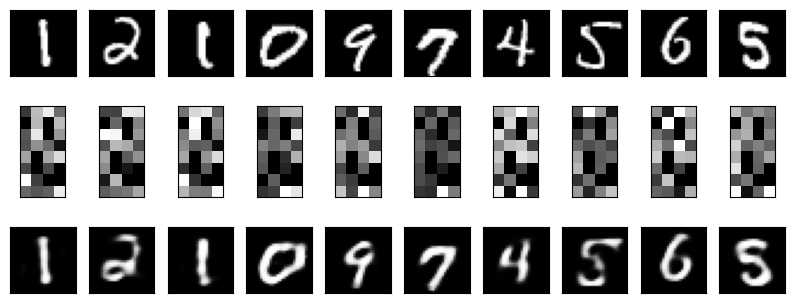

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=numero_imagens, figsize=(10, 4))
for imagens, ax_row in zip([imagens_teste, imagens_codificadas, imagens_decodificadas], axes):
  for img, ax in zip(imagens, ax_row):
    ax.imshow(img, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)